In [5]:
import os
import pickle
import warnings
import dateutil.parser as parser
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from EDA_utils import get_start_dates_tlg
root = 'Telegram_data'

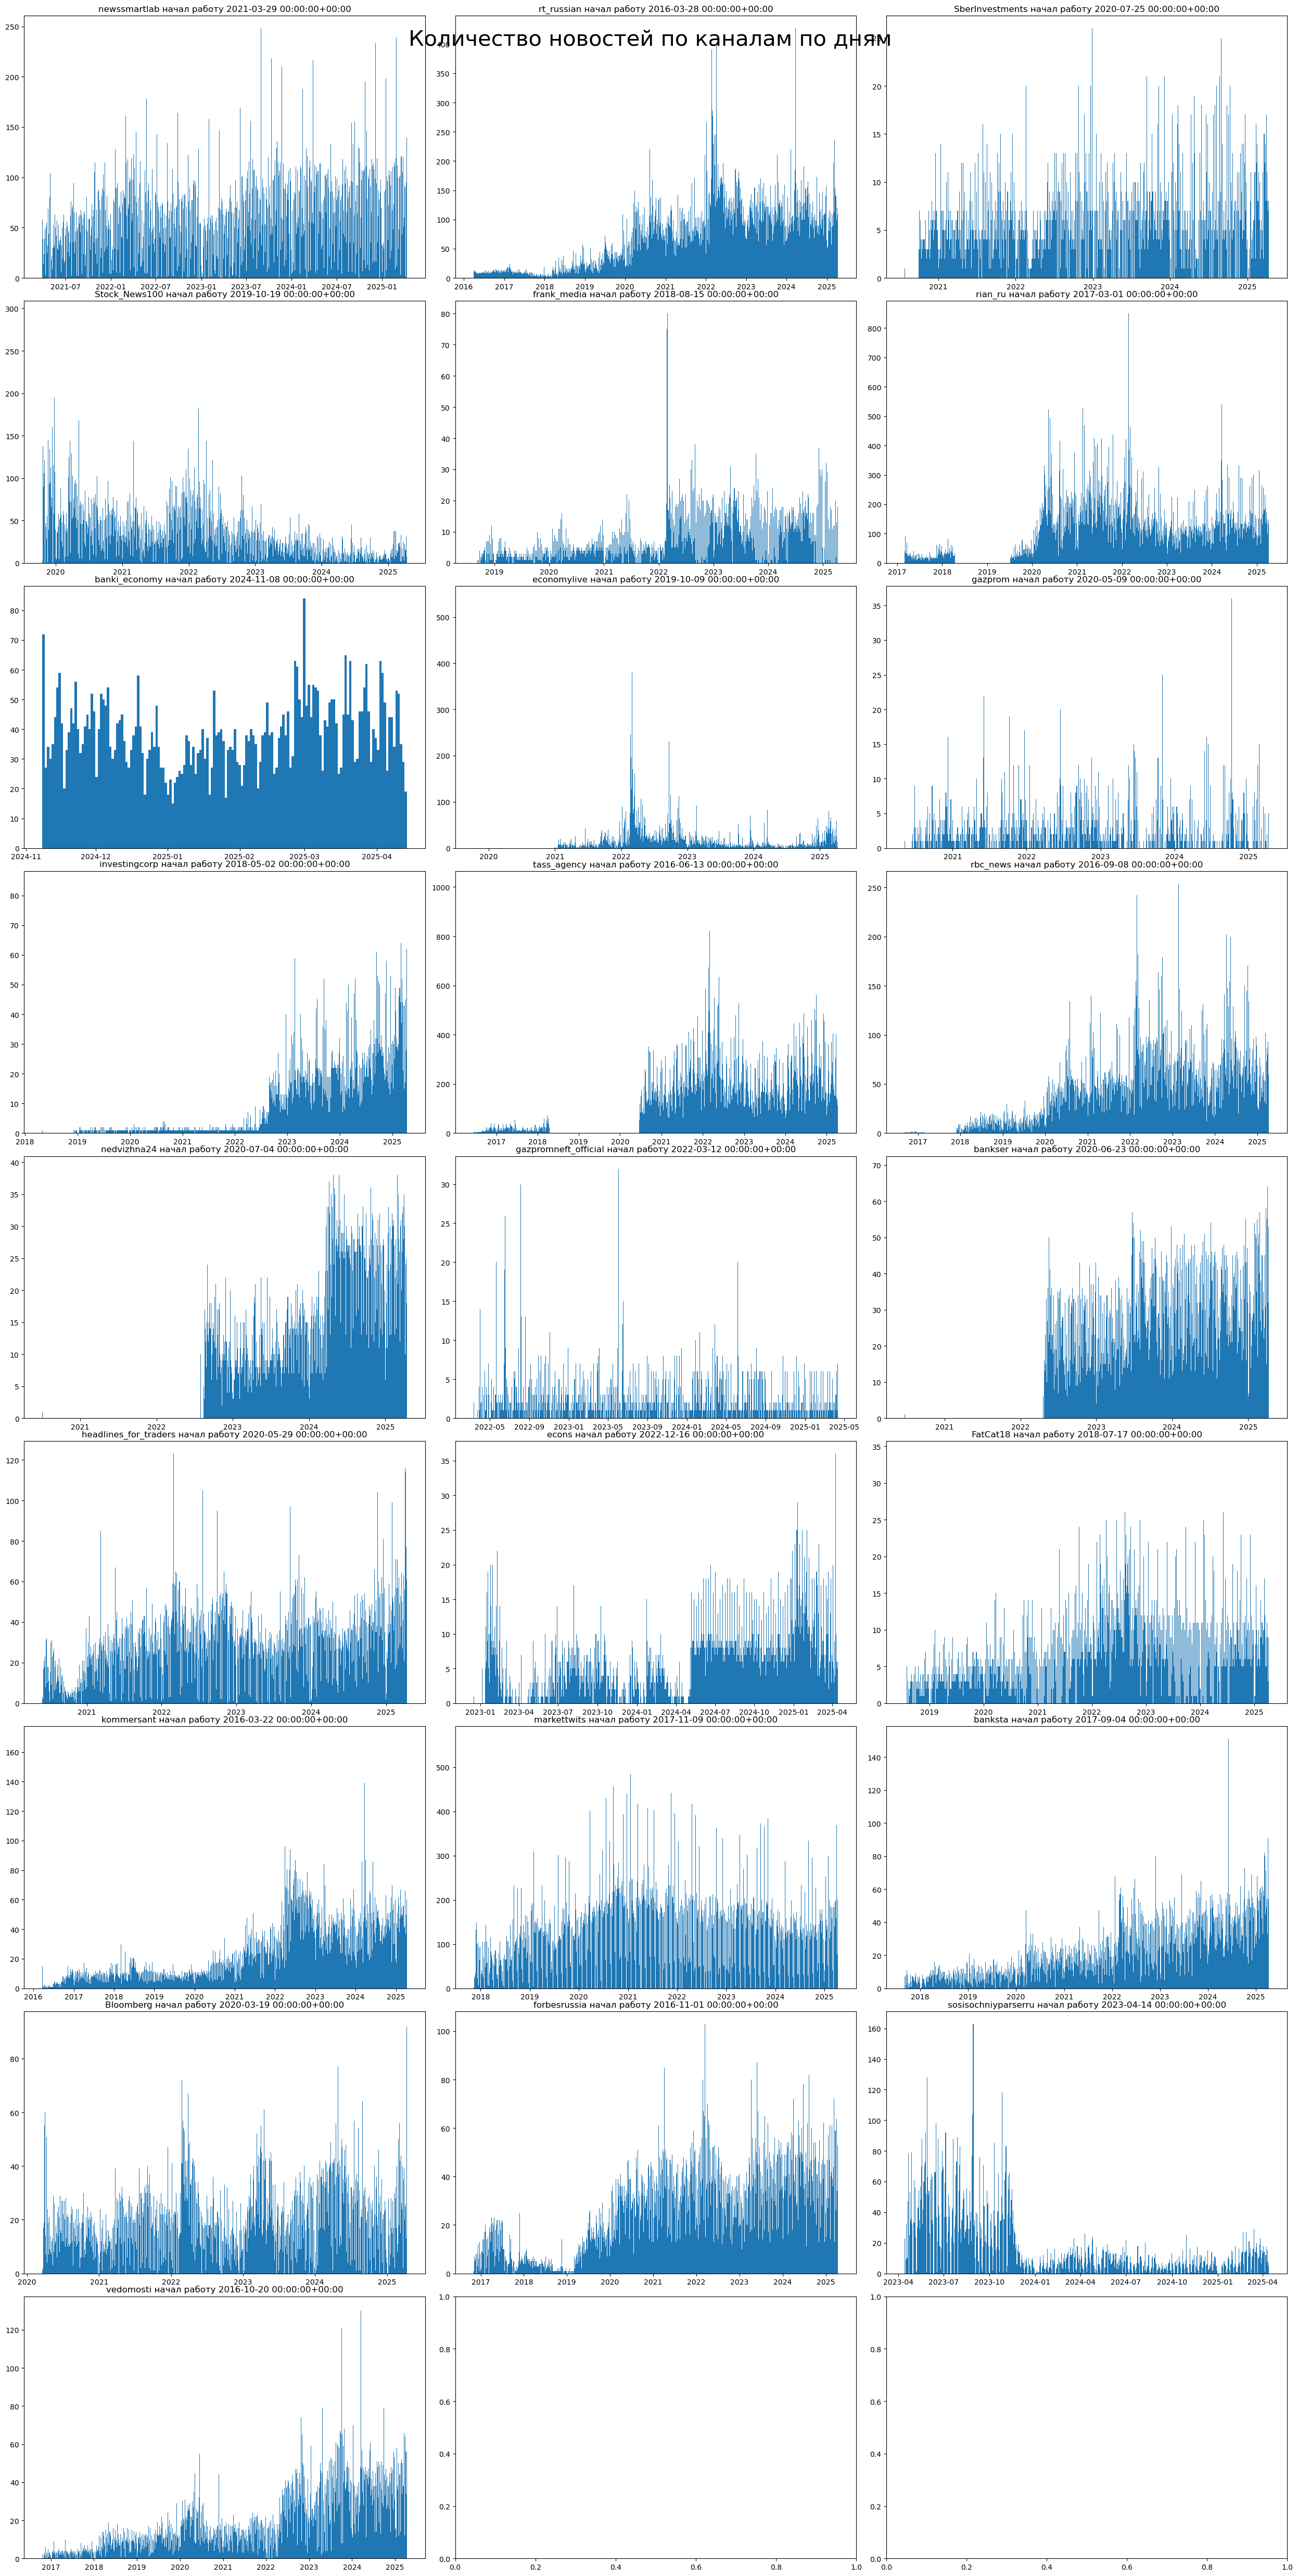

In [4]:
get_start_dates_tlg(root)

In [7]:
from EDA_utils import get_dates_tlg
dates_tg = get_dates_tlg(root)

/Users/irina/Desktop/Master_VKR/code/price_prediction_news/src/EDA_utils.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  dates = pd.concat([dates, tmp], axis=0)


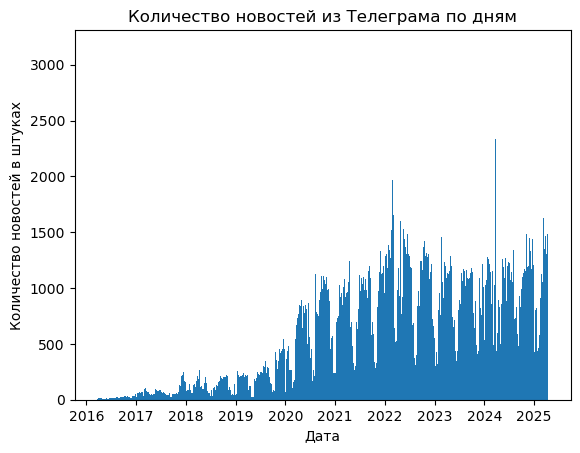

In [11]:
plt.hist(dates_tg, bins=len(np.unique(dates_tg)))
plt.xlabel('Дата')
plt.ylabel('Количество новостей в штуках')
plt.title('Количество новостей из Телеграма по дням')
plt.show()

In [3]:
from EDA_utils import avg_time_tg
avg_time_tg()

,Источник,Минимальное время,Среднее время,Максимальное время
0,rt_russian_messages,0.0,20.402772,4680.0
1,econs_messages,0.0,272.782092,20760.0
2,banki_economy_messages,0.0,37.058246,840.0
3,SberInvestments_messages,0.0,268.779443,6660.0
4,Stock_News100_messages,0.0,43.149104,4200.0
5,kommersant_messages,0.0,59.518584,5520.0
6,headlines_for_traders_messages,0.0,49.370629,8160.0
7,markettwits_messages,0.0,12.519060,5880.0
8,forbesrussia_messages,0.0,56.831313,14160.0
9,investingcorp_messages,0.0,165.026669,21600.0


### Граф связей телеграм каналов

In [3]:
files = os.listdir('Telegram_prep')
files = [f for f in files if f[0]!='.']
#files.remove('messages')
channel_lst = [ch[:-4] for ch in files]
id_lst = ['1099860397', '1036362176', '1038402501', '1075565753', '1101170442',
    '1050820672', '1293298872', '1477408271', '1203560567', '1137955452',
    '1441563903', '1132713042', '1136626166', '1425338344', '1366793743',
    '1308785417', '1727045083', '1408960847', '1087766403', '1940830560',
    '1595965216', '1445969592', '1428717522', '2409669849', '1239405989']
channel_id_dct = {i:j for i,j in zip(channel_lst, id_lst)}
channel_name_dct = {int(j):i for i,j in channel_id_dct.items()} 

In [5]:
edges = []
for file, channel in zip(files, channel_lst):
    df = pd.read_csv(f'Telegram_prep/{file}', low_memory=False)
    df = df[df['fwd_from'].notna()].reset_index(drop=True)
    for idx, row in df.iterrows():
        fwd_from = eval(row['fwd_from'])['from_id']
        if fwd_from is not None and 'channel_id' in fwd_from:
            fwd = fwd_from['channel_id']
            # edges.append([channel, fwd])
            edges.append([int(channel_id_dct[channel]), fwd])

In [6]:
unique, counts = np.unique(edges, return_counts=True)
edges_filtered = unique[counts > 50]

bool_array = []
for edge in edges:
    if (edge[0] in edges_filtered) and (edge[1] in edges_filtered) and (edge[0] in channel_name_dct) and (edge[1] in channel_name_dct):
        bool_array.append(True)
    else:
        bool_array.append(False)

edges_fil = np.array(edges)[bool_array]

In [7]:
edges_fil = np.vectorize(channel_name_dct.get)(edges_fil)

In [8]:
g = nx.DiGraph()
g.add_edges_from(edges_fil)

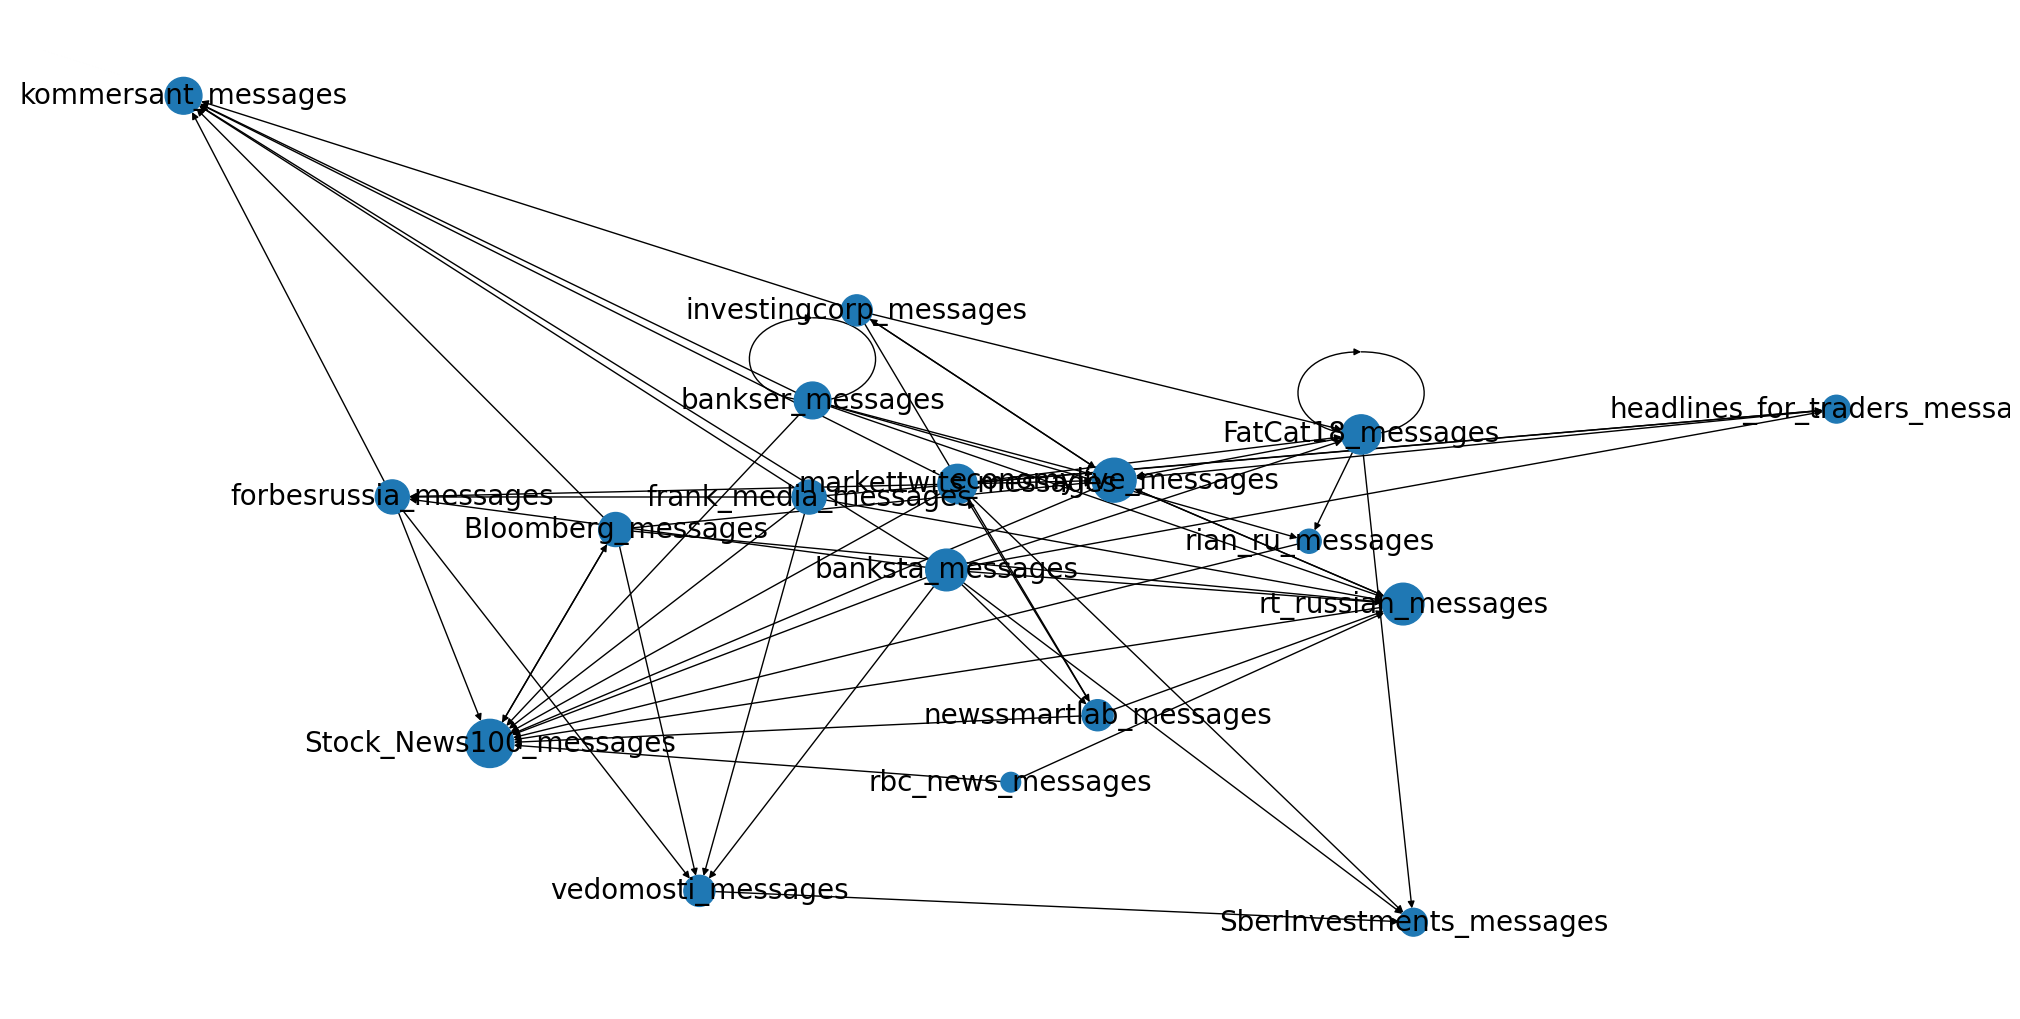

In [9]:
plt.figure(figsize = (20, 10))
pos = nx.spring_layout(g, scale=20, k=3/np.sqrt(g.order()))
d = dict(g.degree)
nx.draw(g, pos, with_labels = True, font_size = 20, node_size=[d[k]*100 for k in d])
plt.show()

###Распределение новостей во времени по компаниям

In [9]:
companies = {
    'ALRS': 'alrosa-ao', 'AFLT': 'aeroflot', 'VTBR': 'vtb', 'GAZP' : 'gazprom', 'GMKN': 'nornickel-gmk', 'LSRG': 'lsr', 
    'DSKY': 'detsky-mir', 'IRAO': 'inter-rao-ao', 'LKOH': 'lukoil', 'MAGN': 'mmk', 'MOEX': 'moscowexchange', 'CBOM': 'oao-mkb-ao', 
    'MTSS': 'mts', 'VKCO': 'gdr-vk-company-limited-ord-shs_vkco-tqbr', 'ROSN': 'rosneft', 'NLMK': 'nlmk-ao', 'NVTK': 'novatek', 'PIKK': 'pik', 
    'PLZL': 'polus-zoloto', 'RTKM': 'rostelecom', 'RUAL': 'united-company-rusal-plc', 'HYDR': 'rusgidro', 'SBER': 'sberbank', 'CHMF': 'severstal-ao', 
    'AFKS': 'afk-sistema', 'SNGS': 'surgut', 'TATN': 'tatneft-3', 'TCSG': 'gdr-tcs-group-holding-ord-shs_tcsg', 'TRNFP': 'transneft-pref', 
    'POGR': 'petropavlovsk-plc_pogr', 'PHOR': 'phosagro-ao', 'FEES': 'fsk-ees', 'HHRU': 'adr-headhunter-group-ord-shs_hhru', 'YNDX': 'pllc-yandex-n-v'}

In [11]:
from EDA_utils import plot_company_news_hist_tg
plot_company_news_hist_tg(companies)

KeyError: "['ALRS', 'AFLT', 'GMKN', 'LSRG', 'DSKY', 'IRAO', 'LKOH', 'MAGN', 'MOEX', 'CBOM', 'MTSS', 'VKCO', 'NLMK', 'PIKK', 'PLZL', 'RTKM', 'RUAL', 'HYDR', 'CHMF', 'AFKS', 'SNGS', 'TATN', 'TCSG', 'TRNFP', 'POGR', 'PHOR', 'FEES', 'HHRU', 'YNDX'] not in index"

In [8]:
import os

root = 'Telegram_data'
files = os.listdir(root)
print("Файлы в папке:", files)

Файлы в папке: ['newssmartlab_messages.json', 'rt_russian_messages.json', 'SberInvestments_messages.json', 'Stock_News100_messages.json', 'frank_media_messages.json', 'rian_ru_messages.json', 'banki_economy_messages.json', 'economylive_messages.json', 'gazprom_messages.json', 'investingcorp_messages.json', 'tass_agency_messages.json', 'rbc_news_messages.json', 'nedvizhna24_messages.json', 'gazpromneft_official_messages.json', 'bankser_messages.json', 'headlines_for_traders_messages.json', 'econs_messages.json', 'FatCat18_messages.json', '.ipynb_checkpoints', 'kommersant_messages.json', 'markettwits_messages.json', 'banksta_messages.json', 'BIoomberg_messages.json', 'forbesrussia_messages.json', 'sosisochniyparserru_messages.json', 'vedomosti_messages.json']
